# HW04: RDD and Diff-in-Diff (due 24th October 23:59)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [3]:
!pip install rdrobust


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\Carti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [28]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
import numpy as np

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)


In [5]:
df = pd.read_stata('data/HW04_data_rdd.dta')

C:\Users\Carti\AppData\Local\Temp\ipykernel_32944\2619628620.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [6]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
df_labels

C:\Users\Carti\AppData\Local\Temp\ipykernel_32944\1581965592.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [7]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 


$$
  pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i 
$$

In [8]:
df.isnull().sum()

uf                        0
nsorteio                  0
totrecursos               0
tot_os                   25
pop                       0
purb                      0
p_secundario              0
cod_ibge6                 0
pib_capita_02             0
op_01_04                  0
reeleito                  0
ENEP2000                  0
ENLP2000                  0
pref_idade_tse            0
comarca                   0
reeleito_2004             0
p_cad_pref                0
rec_transf_correntes      0
gini_ipea                 0
fiscalizacoes             0
valor_fiscalizado         0
incumbent                 0
vereador9600            206
pmismanagement          110
elected1                  0
first                     0
lpib02                    0
lpop                      0
pref_masc                 0
pref_escola               0
media2                    0
vereador_eleit            0
mun_novo                  0
exp_prefeito              0
samepartygov98            0
lrec_trans          

In [9]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col



ols1 = smf.ols("pcorrupt ~ first", data=df).fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:               pcorrupt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.017
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0456
Time:                        18:38:07   Log-Likelihood:                 415.01
No. Observations:                 476   AIC:                            -826.0
Df Residuals:                     474   BIC:                            -817.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0737      0.007     10.428      0.0

**What could be some sources of bias, namely, variables that act as confounder?**

In [10]:
df2  = pd.DataFrame()
df2['pop'] = np.log(df['pop'])
df2['pib_capita_02'] = np.log(df['pib_capita_02'])
df2['first'] = df['first']
df2['mun_novo'] = df['mun_novo']
df2['party'] = df['party']
df2['gini_ipea'] = df['gini_ipea']
df2['purb'] = df['purb']
df2['p_secundario'] = df['p_secundario']
df2['pcorrupt'] = df['pcorrupt']
df2['uf'] = df['uf']


In [11]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols("pcorrupt ~ first  +  C(party) + gini_ipea + p_secundario + purb + pib_capita_02 + pop" , data=df2).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:               pcorrupt   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.960
Date:                Thu, 19 Oct 2023   Prob (F-statistic):            0.00533
Time:                        18:38:07   Log-Likelihood:                 435.63
No. Observations:                 476   AIC:                            -823.3
Df Residuals:                     452   BIC:                            -723.3
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3371      0.096      3.

In [12]:
## display the results 
print(summary_col([ols1,ols2]))


               pcorrupt I pcorrupt II
-------------------------------------
C(party)[T.10]            -0.0138    
                          (0.0345)   
C(party)[T.11]            0.0054     
                          (0.0224)   
C(party)[T.12]            0.0715     
                          (0.0456)   
C(party)[T.13]            -0.0377    
                          (0.0614)   
C(party)[T.14]            -0.0172    
                          (0.0338)   
C(party)[T.15]            0.2798     
                          (0.1016)   
C(party)[T.16]            0.0211     
                          (0.0283)   
C(party)[T.17]            0.0320     
                          (0.1024)   
C(party)[T.18]            0.0185     
                          (0.0229)   
C(party)[T.2]             0.0534     
                          (0.0296)   
C(party)[T.3]             0.0131     
                          (0.0219)   
C(party)[T.4]             0.0228     
                          (0.0242)   
C(party)[T.

**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

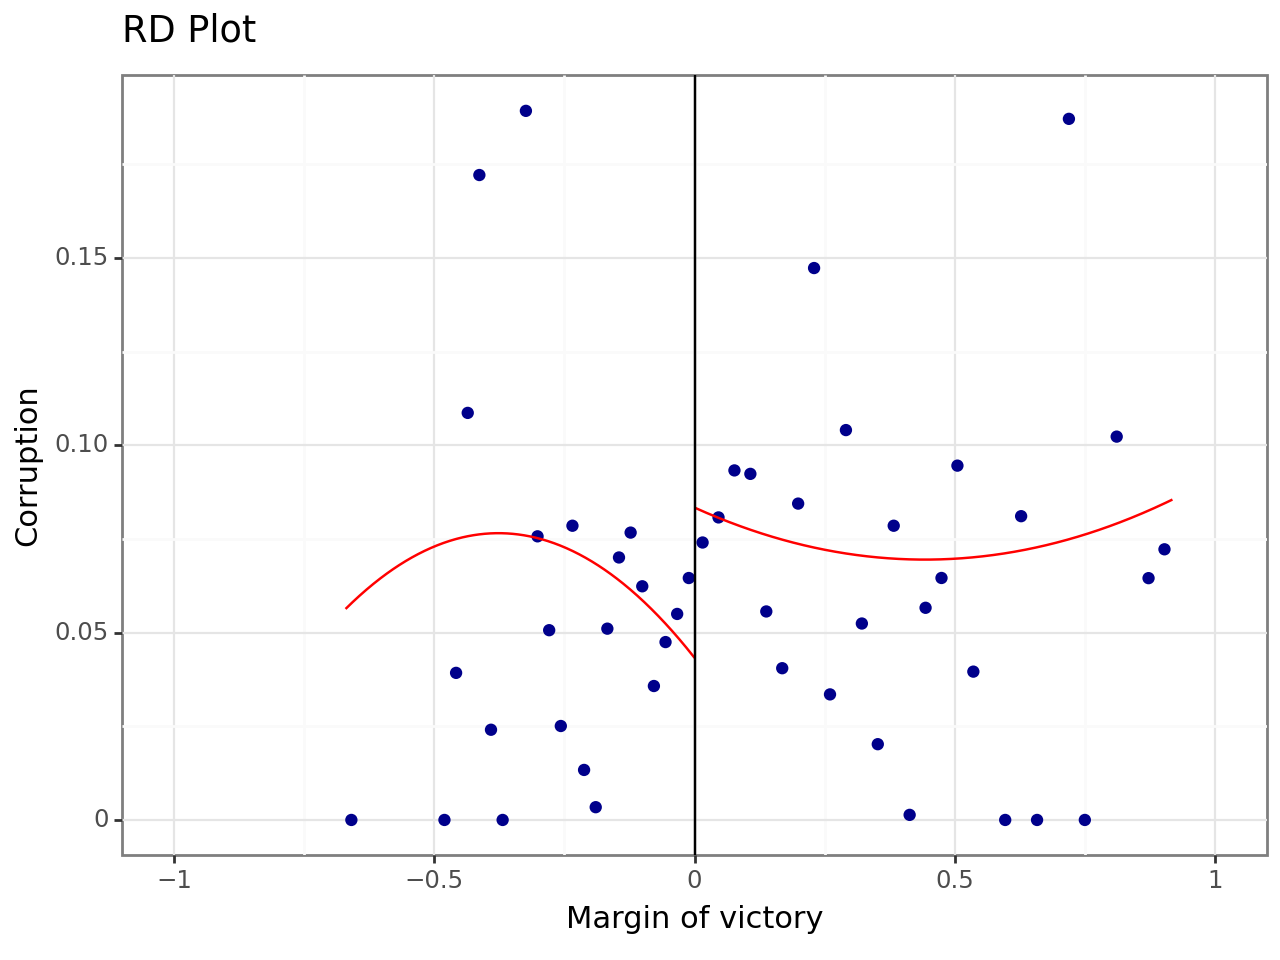


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     30         30
Average Bin Length             0.025      0.031
Median Bin Length              0.022      0.031
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    6.0       10.0
WIMSE variance weight          0.005      0.001
WIMSE bias weight              0.995      0.999


In [13]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt

rdplot(y=corruption, x=margin, nbins=30, masspoints='adjust', p=2,
         
         y_label="Corruption",
         x_label="Margin of victory", x_lim=[-1, 1])

In [14]:
rdrobust(y=corruption, x=margin, p=4)

Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          94        124
Bandwidth Estimation           0.205      0.205
Bandwidth Bias                 0.274      0.274
rho (h/b)                      0.747      0.747

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        0.03    0.041     0.72   4.717e-01     [-0.051, 0.11]
Robust                 -        -    0.904   3.661e-01    [-0.045, 0.121]


In [15]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
covs = pd.concat([df.dropna(subset=['winning_margin'])[['gini_ipea', 'p_secundario' , 'purb' , 'pib_capita_02' , 'pop']]], axis=1)
                 

rdrobust(y=corruption, x=margin, covs=covs, p=4, vce='hc0')

Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC0

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          90        105
Bandwidth Estimation           0.171      0.171
Bandwidth Bias                 0.234      0.234
rho (h/b)                      0.733      0.733

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.031    0.044    0.717   4.731e-01    [-0.054, 0.117]
Robust                 -        -    0.979   3.275e-01     [-0.043, 0.13]


**Interpret the coefficient**

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [16]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
df_labels

C:\Users\Carti\AppData\Local\Temp\ipykernel_32944\1792503655.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'observ': 'block id',
 'barrio': 'neighborhood',
 'calle': 'street',
 'altura': 'street numbering',
 'institu1': 'dummy Jewish institution in the block',
 'institu3': 'dummy Jewish institution one block away',
 'distanci': 'block distance to closest institution',
 'edpub': 'dummy public building/embassy',
 'estserv': 'dummy gas station',
 'banco': 'dummy bank',
 'totrob': 'car theft',
 'mes': 'month',
 'inst3_1': '',
 'month5': '',
 'post': '',
 'inst1p': '',
 'inst3_1p': ''}

In [17]:
df.head()

,observ,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,mes,inst3_1,month5,post,inst1p,inst3_1p
0,870.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,851.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,843.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,796.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
4,790.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 
$$
totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i
$$


In [18]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols = smf.ols("totrob ~ inst1p", data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 totrob   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.82
Date:                Thu, 19 Oct 2023   Prob (F-statistic):            0.00101
Time:                        18:38:08   Log-Likelihood:                 4.5306
No. Observations:                7884   AIC:                            -5.061
Df Residuals:                    7882   BIC:                             8.884
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0943      0.003     34.222      0.0

**Why this estimate CANNOT be interpreted as causal?**

Because we need to take in consideration that before the terrorist attack, the police forces didn't concentrate their resources in the jewish neighborhoods, and thus it's possible there wasn't a lot of data collected in those areas. Maybe the decrease of car theft doesn't really exist. The contrary could also happen, meaning a decrease of data collected in the other areas after the attacks.  

Basically we need to account what the situation was before the attacks.


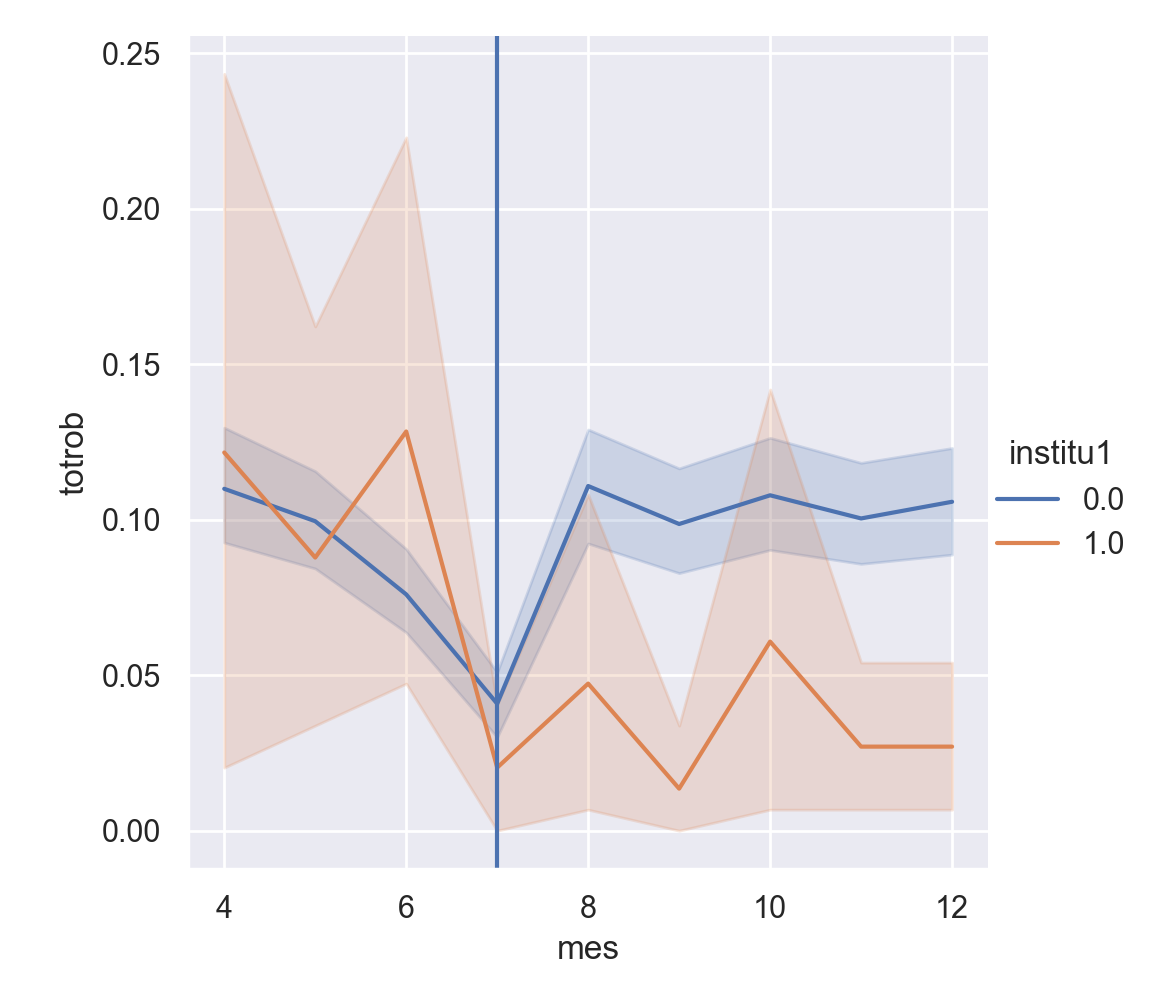

In [33]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df, x="mes", y="totrob", hue="institu1" ,kind="line")
plt.axvline(x=7)

<Axes: xlabel='distanci', ylabel='totrob'>

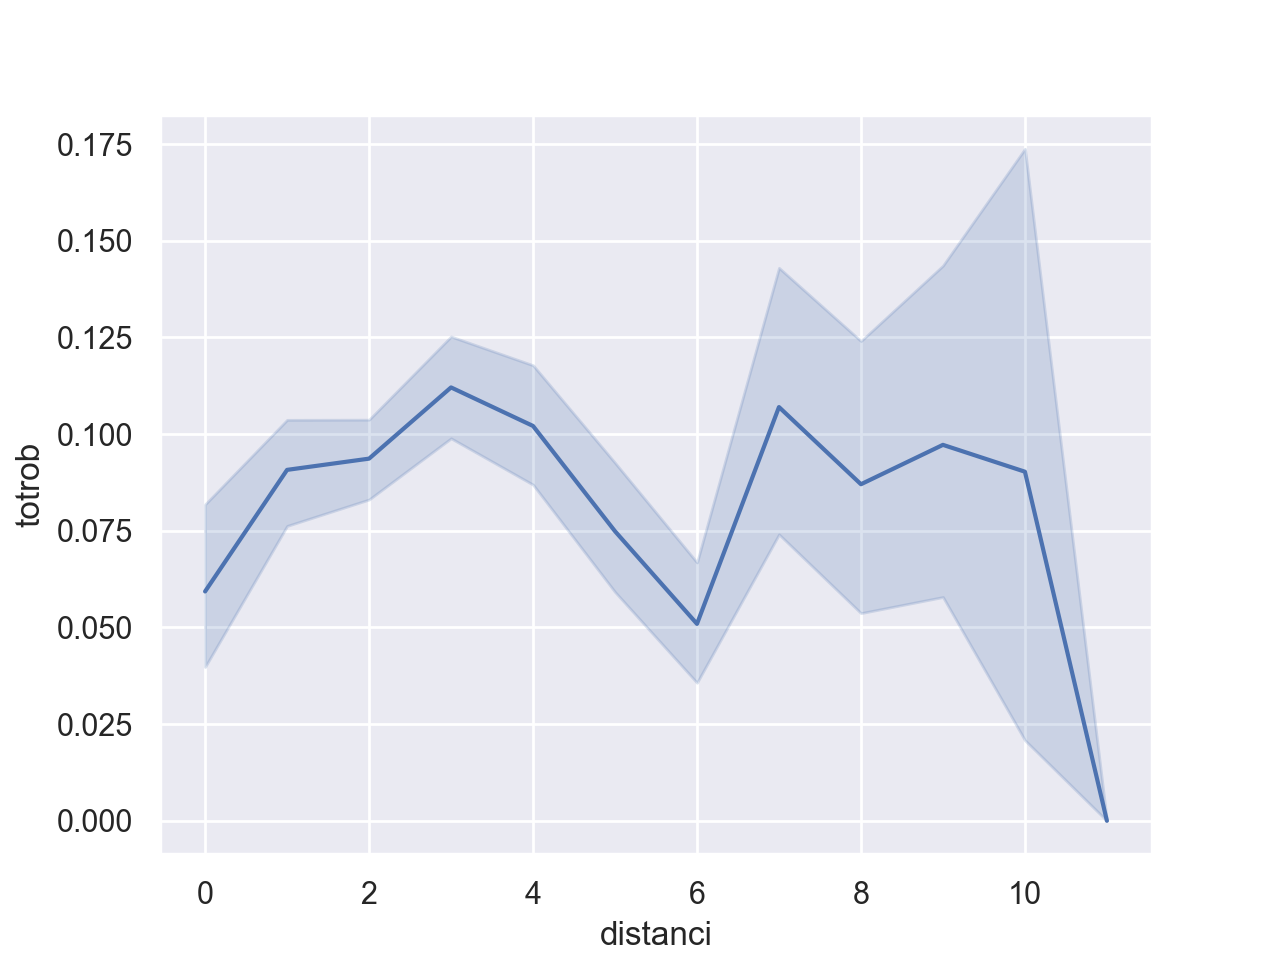

In [35]:
sns.lineplot(data=df, x="distanci", y="totrob")

**Does the parallel trend assumption hold?**

In [38]:
##Run the regression above including month and block fixed effects
from linearmodels import PanelOLS


did = df.set_index(['barrio', 'mes'])
did = PanelOLS(did.totrob, did.institu1, entity_effects=True, time_effects=True).fit(cov_type = 'clustered', cluster_entity=True)
did

Dep. Variable:,totrob,R-squared:,9.622e-05
Estimator:,PanelOLS,R-squared (Between):,-0.0118
No. Observations:,7884,R-squared (Within):,9.55e-05
Date:,"Thu, Oct 19 2023",R-squared (Overall):,-0.0010
Time:,18:53:33,Log-likelihood,82.300
Cov. Estimator:,Clustered,,
,,F-statistic:,0.7575
Entities:,3,P-value,0.3841
Avg Obs:,2628.0,Distribution:,"F(1,7872)"
Min Obs:,1377.0,,
Max Obs:,4167.0,F-statistic (robust):,3.0523


In [48]:
##show the results from both regressions
print(summary_col([ols]))
print(did)


                totrob 
-----------------------
Intercept      0.0943  
               (0.0028)
inst1p         -0.0592 
               (0.0180)
R-squared      0.0014  
R-squared Adj. 0.0012  
Standard errors in
parentheses.
                          PanelOLS Estimation Summary                           
Dep. Variable:                 totrob   R-squared:                     9.622e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0118
No. Observations:                7884   R-squared (Within):             9.55e-05
Date:                Thu, Oct 19 2023   R-squared (Overall):             -0.0010
Time:                        18:53:33   Log-likelihood                    82.300
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7575
Entities:                           3   P-value                           0.3841
Avg Obs:                       2628.0   Distri

**Compare and interpret the results**

From what we see there's a slight decrease for the coefficient, but not as big as when we only look at the post attack situation.